# Weather features prediction 

# Data preprocessing


We consider two cases.  
First we develop one model to predict the temperature, and other model to predict precipitation.
We are going to show first the related functions and imports

In [ ]:
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from random import random
import tensorflow as tf
import csv

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from hyperas import optim
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation

from keras.callbacks import EarlyStopping, ModelCheckpoint
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

During this excersise we use hyperas to help us evaluate the hyperparameters optimization
For both cases we use the same normalize function

In [ ]:
# NORMALIZE DATASET 
def normalize(x, stats):
    return (x - stats['mean']) / stats['std']

We select a window of 5000, in this case for finding X and Y

In [ ]:
def segment(dataset, variable, window = 5000, future = 0):
        data = []
        labels = []
        for i in range(len(dataset)):
            start_index = i
            end_index = i + window
            future_index = i + window + future
            if future_index >= len(dataset):
                break
            data.append(dataset[variable][i:end_index])
            labels.append(dataset[variable][end_index:future_index])
        return np.array(data), np.array(labels)

### Hyperas optimization

The function Data es reading the csv files, normalize the data and segment the data into test, train and validation sets.

In [ ]:
def data():
    TIMESTEP = '720T'
    HISTORY_LAG = 100
    FUTURE_TARGET = 50
    nw_16_url = './data/NW2016.csv'
    nw_17_url = './data/NW2017.csv'
    nw_18_url = './data/NW2018.csv'

    NW2016_dataset = pd.read_csv(nw_16_url, header = 0, sep = ',', quotechar= '"', error_bad_lines = False)
    NW2017_dataset = pd.read_csv(nw_17_url, header = 0, sep = ',', quotechar= '"', error_bad_lines = False)
    NW2018_dataset = pd.read_csv(nw_18_url, header = 0, sep = ',', quotechar= '"', error_bad_lines = False)
    
    data = pd.concat([NW2016_dataset, NW2017_dataset, NW2018_dataset])
    data = NW2016_dataset
    data = data[data.isna()['psl'] == False]
    #Drop useless columns
    data = data.drop(columns = ['lat', 'lon', 'height_sta'], axis = 1)

    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d %H:%M')
    data.set_index('date', inplace=True)
    
    #Interpolate missing values
    data = data.interpolate(method='linear')

    stats = data.describe()
    stats = stats.transpose()
    data = normalize(data, stats)
    
    resample_ds = data.resample(TIMESTEP).mean()

    train_ds = resample_ds.sample(frac=0.7)
    test_ds = resample_ds.drop(train_ds.index)

    X_train, y_train = segment(train_ds, "td", window = HISTORY_LAG, future = FUTURE_TARGET)
    X_train = X_train.reshape(X_train.shape[0], HISTORY_LAG, 1)
    y_train = y_train.reshape(y_train.shape[0], FUTURE_TARGET, 1)

    X_test, y_test = segment(train_ds, "td", window = HISTORY_LAG, future = FUTURE_TARGET)
    X_test = X_test.reshape(X_test.shape[0], HISTORY_LAG, 1)
    y_test = y_test.reshape(y_test.shape[0], FUTURE_TARGET,)

    print(len(X_train), 'train sequences')
    print(len(X_test), 'test sequences')

    
    print('X_train shape:', X_train.shape)
    print('X_test shape:', X_test.shape)

    return X_train, X_test, y_train, y_test

For the precipitation prediction this is the change that is made in this function

In [ ]:
    X_train, y_train = segment(train_ds, "precip", window = HISTORY_LAG, future = FUTURE_TARGET)
    X_train = X_train.reshape(X_train.shape[0], HISTORY_LAG, 1)
    y_train = y_train.reshape(y_train.shape[0], FUTURE_TARGET, 1)

    X_test, y_test = segment(train_ds, "precip", window = HISTORY_LAG, future = FUTURE_TARGET)
    X_test = X_test.reshape(X_test.shape[0], HISTORY_LAG, 1)
    y_test = y_test.reshape(y_test.shape[0], FUTURE_TARGET,)

As showed above, data was merged in just one big dataset where all the NaN values are covered with a linear interpolation function. Then, a normalization process is made with the substraction of the average value to each observation andi dividing it in the standard deviation value. Also date column is processed with a function to be able to manage it in the future.

Another relevant function defined for data processing is "segment", that allow us to create training and labels arrays with an specific window to predict "n" elements in the future

There is a key step in the code showed above and is the "resample" function to combine the results of the entries gave an specific timestep. For this exercise, a timestep of 12 hours was defined to predict the future 50 entries.

# Model construction step

Now, we are able to create the neural network model with keras, both models for precipitation and temperature prediction are shown bellow:

In [ ]:
#Model the NN
def model(X_train, X_test, y_train, y_test):

    HISTORY_LAG = 100
    model = tf.keras.models.Sequential()
    model.add(LSTM(HISTORY_LAG, input_shape=X_train.shape[-2:]))
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(1))
    model.add(Activation('relu'))
    model.compile(optimizer='adam',
                       metrics=['mae', 'mse'], loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)
    model.fit(X_train, y_train,
              batch_size={{choice([32, 64, 128])}},
              epochs={{choice([100, 200, 500, 1000])}},
              validation_split=0.08,
              callbacks=[early_stopping, checkpointer])
    loss, mae, mse  = model.evaluate(X_test, y_test, verbose=0)

    print('Test mae:', mae)
    print('Test mse:', mse)
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

Some of the parameters that are able to be defined in the model initialization are optimized using "Hyperas", an opensource library that runs the defined model multiple times and make some analyzis to choose the best combination of hyperparameters like training epochs, bratch_size, number of neurons per layer, among other features.

Finally, a main method is defined to orchestrate the execution of the methods defined before:

In [ ]:
if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=model,
                                          data=data,
                                          algo=tpe.suggest,
                                          max_evals=10,
                                          trials=Trials())
    print(best_run)
    print(best_model)

The "optimize" method is the one in charge to choose the best comination of hyperparameters to improve model predictions.

# Results

Based on the outputs received from the hyperas optimizer, the best combination of the hyperparams for each model are the following ones:

td prediction:



precip prediction model:

{'Activation': tanh, 
    'Dropout': 0.3746350041674067, 
    'batch_size': 128, 
    'epochs': 1000, 
    'units': 100
} 

Now, having the best hyperparameters combination, the prediction model is build:

In [ ]:
def model(X_train, X_test, y_train, y_test):

    model = tf.keras.models.Sequential()
    model.add(LSTM(units=100, input_shape=X_train.shape[-2:]))
    model.add(Dropout(0.3746350041674067))
    model.add(Dense(1))
    model.add(Activation('tanh'))
    model.compile(optimizer='adam',
                       metrics=['mae', 'mse'], loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=4)
    checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                                   verbose=1,
                                   save_best_only=True)
    model.fit(X_train, y_train,
              batch_size=128,
              epochs=1000,
              validation_split=0.08,
              callbacks=[early_stopping, checkpointer])
    
    loss, mae, mse  = model.evaluate(X_test, y_test, verbose=0)

    print(' mae:', mae)
    print(' mse:', mse)
    print(' loss:', loss)
    return model

Then, after comparing the predictions made by the model and the real values, the results obtained were the following ones:

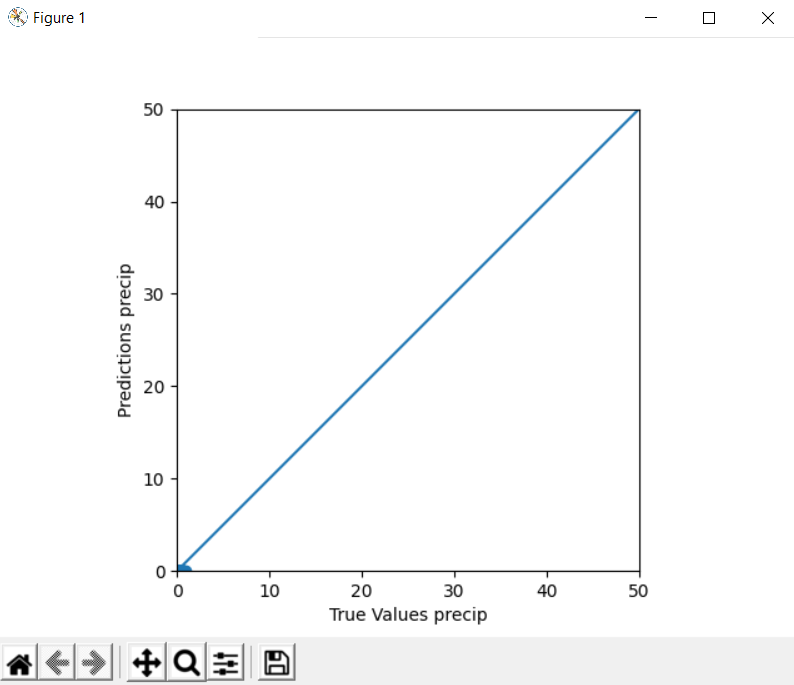

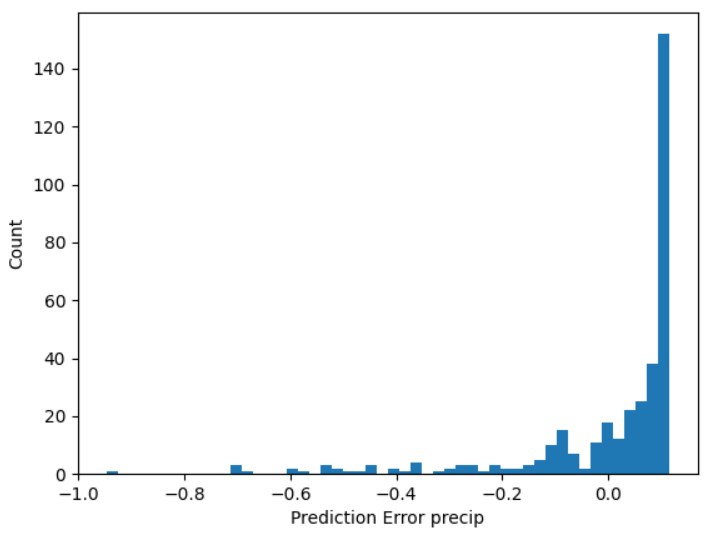